## 1. Предобработка
Выполняем все те же операции, что и в бейслайне

In [30]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, TargetEncoder, RobustScaler
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from lightgbm import LGBMClassifier
from helper import *
from plots import *
import random

In [2]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском 
SEED = 42 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

In [39]:
df = pd.read_csv("data.csv", sep=";")

In [40]:
df.head(4)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no


## 1. Предобработка

In [41]:
# Общие преобразования
df_preprocessed = df.copy()

num_cols = ['balance', 'age', 'day','duration','campaign','pdays','previous']
for c in num_cols:
    df_preprocessed[c] = pd.to_numeric(df_preprocessed[c], errors='coerce')

for c in ['job','marital','education','default','housing','loan','contact','poutcome','month','y']:
    df_preprocessed[c] = df_preprocessed[c].astype('category')

# Упорядочим month
#months_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
#df_preprocessed['month'] = pd.Categorical(df_preprocessed['month'], categories=months_order, ordered=True)
# флаг для специального значения pdays == -1
df_preprocessed['pdays_never'] = (df_preprocessed['pdays'] == -1).astype('int8')

# Кодирование таргета
df_preprocessed['y'] = np.where(df_preprocessed['y'] == 'yes', 1, 0)

df_preprocessed.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pdays_never
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,1


In [42]:
# делим данные на признаки и таргет
X, y = divide_data(df_preprocessed, 'y')

In [43]:
categorical_cols = ['job','marital','education','default','housing','loan',
                    'contact','month','poutcome']
numeric_cols = ['age','balance','day','campaign','pdays','previous','pdays_never']

# Будем использовать порядковое кодирование. Для этого выпишем все категории для каждого столбца в порядке увеличения номера
cat_orders = [
    # job
    ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
     'retired', 'self-employed', 'services', 'student', 'technician',
     'unemployed', 'unknown'],
    # marital
    ['divorced', 'married', 'single'],
    # education
    ['primary', 'secondary', 'tertiary', 'unknown'],
    # default / housing / loan
    ['no', 'yes'],
    ['no', 'yes'],
    ['no', 'yes'],
    # contact
    ['unknown', 'telephone', 'cellular'],
    # month
    ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
    # poutcome
    ['failure', 'other', 'success', 'unknown']
]

# пайплайн
preprocessor = Pipeline([
    ('nan_remover', ColumnTransformer(
        transformers=[
            ('most_frequent_numeric', SimpleImputer(strategy='most_frequent'), numeric_cols),
            ('most_frequent_cat',    SimpleImputer(strategy='most_frequent'), categorical_cols),
            ('mean',                 SimpleImputer(strategy='mean'),          [])
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('transformations', ColumnTransformer(
        [('encoder', OrdinalEncoder(categories=cat_orders), categorical_cols)],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
])
preprocessor.set_output(transform='pandas')

,steps,"[('nan_remover', ...), ('transformations', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('most_frequent_numeric', ...), ('most_frequent_cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [44]:
# сохраним все бейслайн модели в виде списка для удобства
models = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('LGBMClassifier', LGBMClassifier(random_state=SEED))
]

In [45]:
# используем 5-блочную кросс-валидацию, учитывающую распределение таргета при разбиении
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

Удаляем duration, тк это утечка, длительность звонка известна только после контакта и фактически отражает интерес клиента; duration почти напрямую коррелирует с y (дольше говорят — чаще оформляют), из-за чего метрики взлетают нечестно.

In [46]:
cols_to_drop = ['duration']
X = X.drop(columns=cols_to_drop).copy()

In [47]:
#cv = TimeSeriesSplit(n_splits=5)  # expanding window, shuffle=False по умолчанию

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [bin

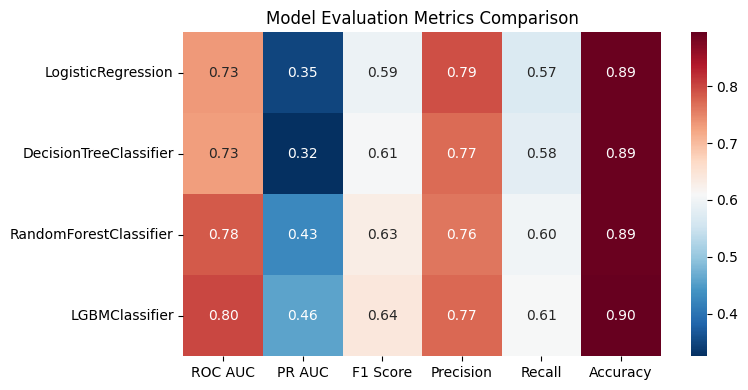

In [48]:
initial_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

## 2. Преобразования данных и feature engineering

### 2.1 Логарифмическое преобразование
В нашем датасете имеются "денежные" признаки balance, campaign, previous, которые имеют асимметричное распределение. Логарифмирование позволит сделать их более нормальными

#### 2.1.1 Без удаления столбцов

In [13]:
X_log = X.copy()

In [14]:
def signed_log1p(s):
    """лог с сохранением знака (для balance, где есть отрицательные)"""
    return np.sign(s) * np.log1p(np.abs(s))

In [15]:
X_log['balanceLog']  = signed_log1p(X_log['balance'])
X_log['campaignLog'] = np.log1p(X_log['campaign'])
X_log['previousLog'] = np.log1p(X_log['previous'])

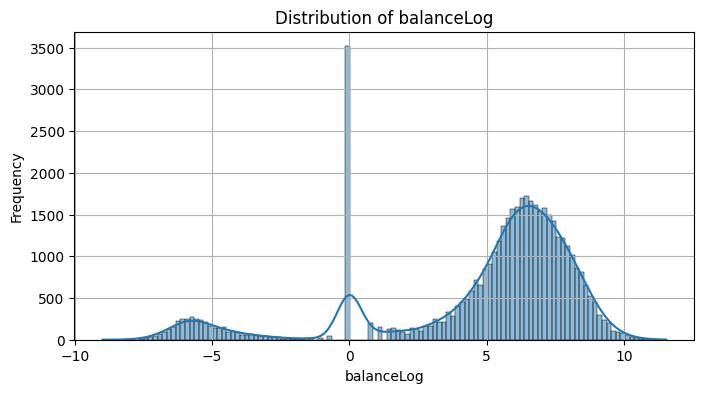

In [16]:
plot_hist_numeric(X_log, 'balanceLog')

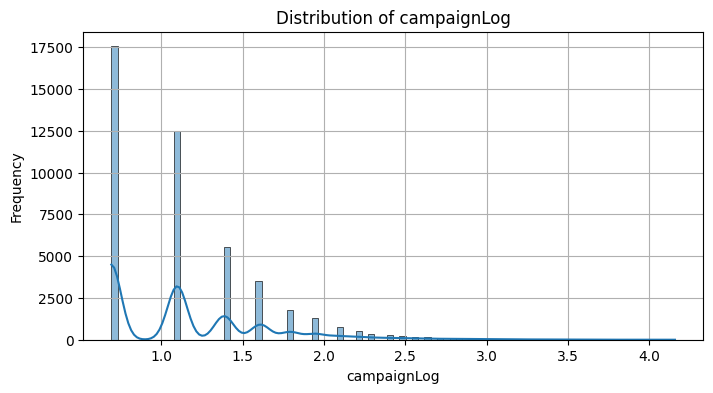

In [17]:
plot_hist_numeric(X_log, 'campaignLog')

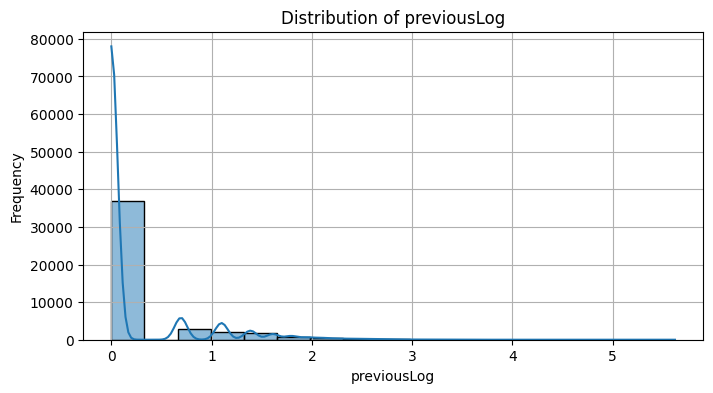

In [18]:
plot_hist_numeric(X_log, 'previousLog')

логарифмирование помогло, но распределения всё ещё не нормальные; главные причины — нули/дискретность (campaign, previous) и смесь знаков (balance).

In [19]:
#добавим новую колонку в препроцессор, чтобы пропуски в ней также заполнились
preprocessor_log = clone(preprocessor)
preprocessor_log['nan_remover'].transformers[2][2].append('balanceLog')

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1065
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 19
[LightGBM] [Info] [b

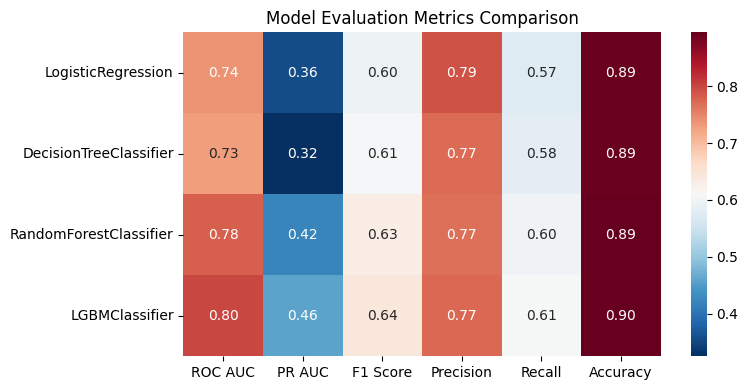

In [20]:
log_metrics = train_evaluate_models_cv(
    models=models,
    X=X_log,
    y=y,
    preprocessor=preprocessor_log,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.003792  0.007672  0.003710  -0.001151  0.002517   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.004441 -0.004225 -0.001644   0.004979 -0.001705   
 LGBMClassifier          0.000000  0.000000  0.000000   0.000000  0.000000   
 
                         Accuracy  
 LogisticRegression      0.000243  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000465  
 LGBMClassifier          0.000000  )

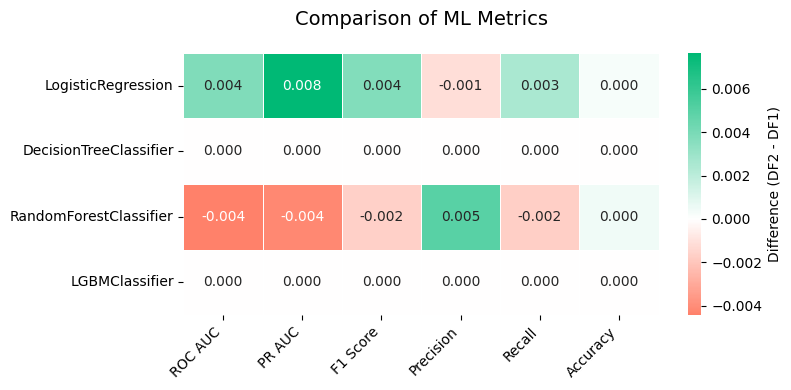

In [21]:
# сравним изначальные метрики с метриками после логарифмирования и выведем график
compare_metrics_heatmap(initial_metrics, log_metrics)

улучшений особо нет

#### 2.1.2 С удалением исходных столбцов

In [22]:
X_log_delete = X.copy()

In [23]:
X_log_delete['balanceLog']  = signed_log1p(X_log_delete['balance'])
X_log_delete['campaignLog'] = np.log1p(X_log_delete['campaign'])
X_log_delete['previousLog'] = np.log1p(X_log_delete['previous'])

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1065
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 19
[LightGBM] [Info] [b

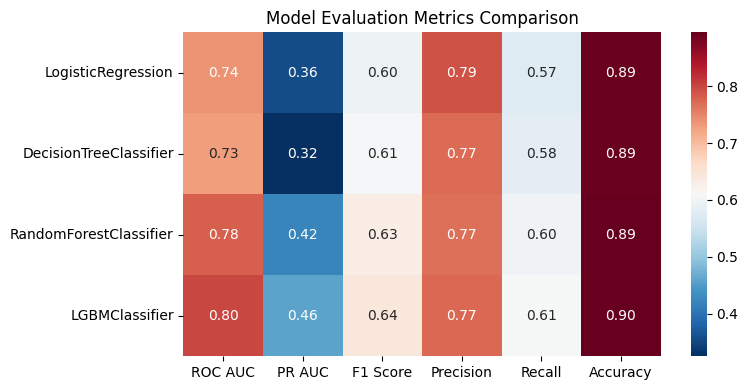

In [24]:
log_delete_metrics = train_evaluate_models_cv(
    models=models,
    X=X_log_delete,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.003792  0.007672  0.003710  -0.001151  0.002517   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.004441 -0.004225 -0.001644   0.004979 -0.001705   
 LGBMClassifier          0.000000  0.000000  0.000000   0.000000  0.000000   
 
                         Accuracy  
 LogisticRegression      0.000243  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000465  
 LGBMClassifier          0.000000  )

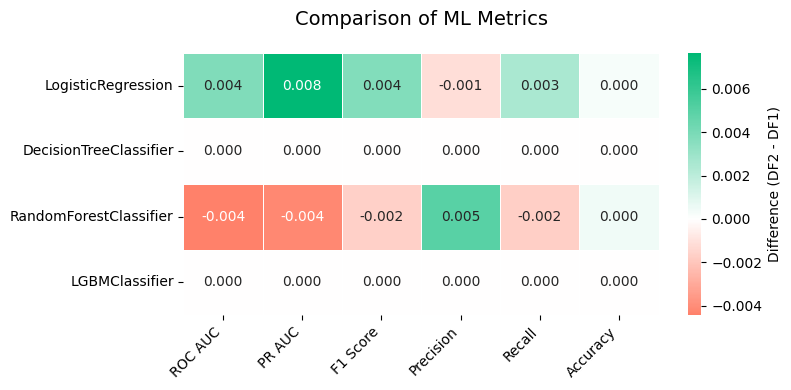

In [25]:
compare_metrics_heatmap(initial_metrics, log_delete_metrics)

C удалением столбцов преобразование работает хуже

### 2.2 Создание нового признака "TotalContacts"
Общее число контактов за всю историю: текущая кампания + прошлые контакты

In [49]:
X_total = X.copy()

In [50]:
X_total["TotalContacts"] = (
    X_total["campaign"].fillna(0) + X_total["previous"].fillna(0)
)
#X_total = X_total.drop(columns=["campaign", "previous"])

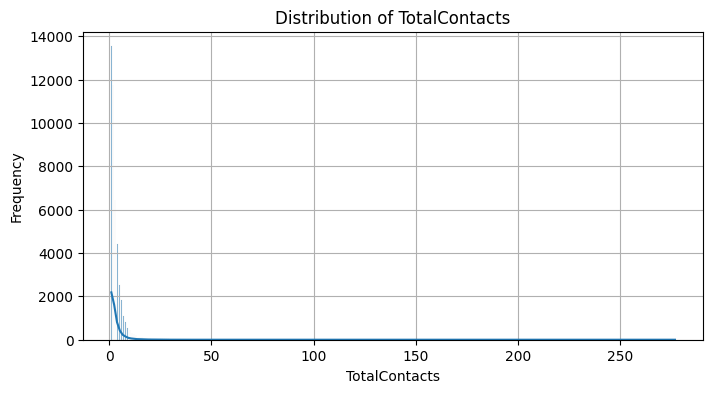

In [51]:
plot_hist_numeric(X_total, 'TotalContacts')

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 780
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 17
[LightGBM] [Info] [bin

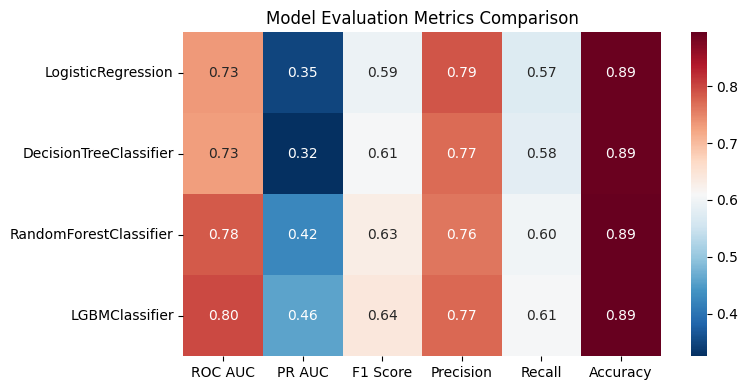

In [52]:
total_income_metrics = train_evaluate_models_cv(
    models=models,
    X=X_total,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression     -0.000225 -0.000559  0.000679  -0.004884  0.000575   
 DecisionTreeClassifier -0.000182 -0.000013  0.000493   0.000289  0.000366   
 RandomForestClassifier -0.000855 -0.001215 -0.000666   0.000178 -0.000574   
 LGBMClassifier         -0.002183 -0.000622 -0.001496  -0.000909 -0.001192   
 
                             Accuracy  
 LogisticRegression     -2.875152e-04  
 DecisionTreeClassifier  6.634966e-05  
 RandomForestClassifier  2.690578e-08  
 LGBMClassifier         -2.211998e-04  )

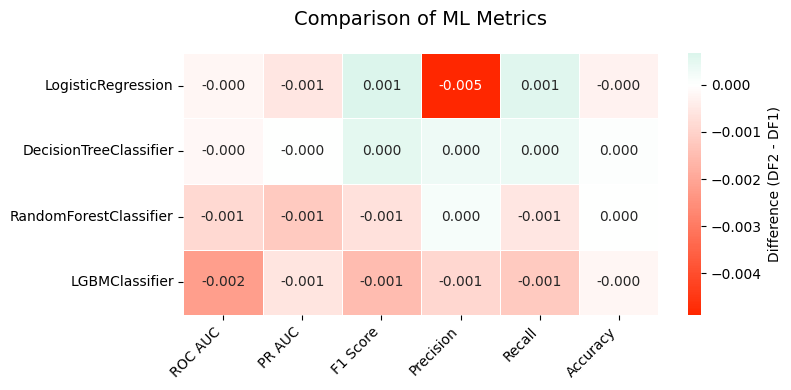

In [53]:
compare_metrics_heatmap(initial_metrics, total_income_metrics)

Наблюдаем ухудшение всех метрик

### 2.3 HasAnyCredit есть ли у клиента какие-то кредиты (ипотека или потребкредит)

In [54]:
X_has = X.copy()

In [55]:
X_has["HasAnyCredit"] = np.where(
    (X_has["housing"].fillna("no") == "yes") | (X_has["loan"].fillna("no") == "yes"),
    1, 0
).astype("int8")

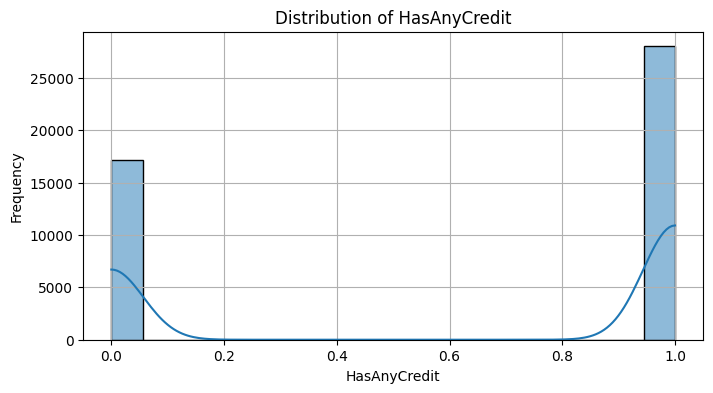

In [56]:
plot_hist_numeric(X_has, 'HasAnyCredit')

In [57]:
preprocessor_lir = clone(preprocessor)
preprocessor_lir['nan_remover'].transformers[2][2].append('HasAnyCredit')

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 17
[LightGBM] [Info] [bin

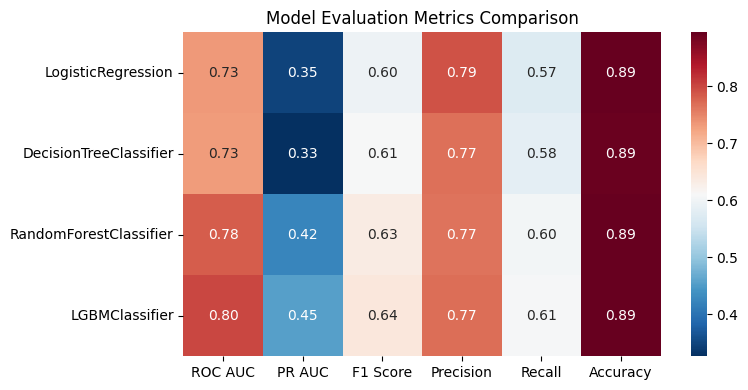

In [58]:
lir_metrics = train_evaluate_models_cv(
    models=models,
    X=X_has,
    y=y,
    preprocessor=preprocessor_lir,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000150  0.000758  0.002407  -0.002885  0.001654   
 DecisionTreeClassifier  0.000958  0.001791  0.002009  -0.005598  0.001616   
 RandomForestClassifier -0.003351 -0.001429  0.002318   0.003976  0.001688   
 LGBMClassifier         -0.001314 -0.002310 -0.001181  -0.004351 -0.000654   
 
                         Accuracy  
 LogisticRegression      0.000022  
 DecisionTreeClassifier -0.000332  
 RandomForestClassifier  0.000664  
 LGBMClassifier         -0.000575  )

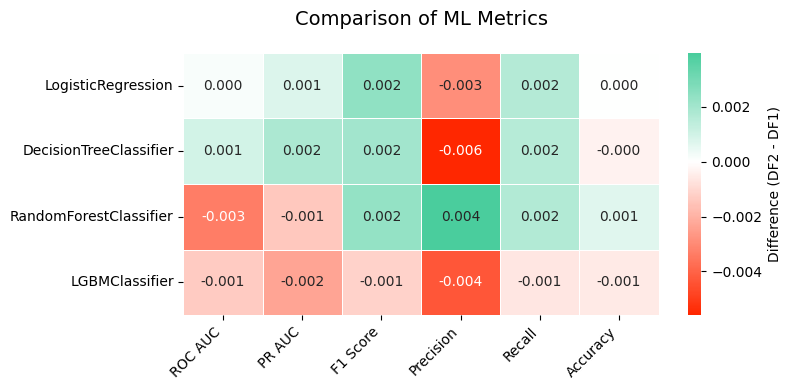

In [59]:
compare_metrics_heatmap(initial_metrics, lir_metrics)

Видны небольшие колебания

сочетать «частоту и давность» контактов (total_contacts, contact_intensity, pdays_recency), добавить простые финансовые взаимодействия (balance_per_age, any_loan/loan_count) и учесть сезонность (month_sin/cos).

c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1559
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 25
[LightGBM] [Info] [b

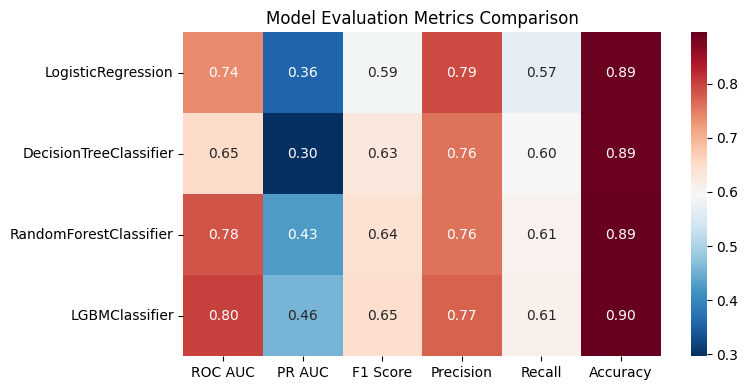

,ROC AUC,PR AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.738162,0.356033,0.588009,0.790577,0.566393,0.891929
DecisionTreeClassifier,0.653642,0.296296,0.627051,0.759218,0.596465,0.892172
RandomForestClassifier,0.784768,0.425241,0.640972,0.758085,0.607973,0.892946
LGBMClassifier,0.799758,0.456239,0.645772,0.772384,0.610949,0.895158


In [60]:
# 1) Cоздаём продвинутые признаки
X_fe = X.copy()

# --- контакты и "давление" кампании ---
X_fe["total_contacts"]   = X_fe["campaign"].fillna(0) + X_fe["previous"].fillna(0)
X_fe["was_contacted"]    = (X_fe["previous"].fillna(0) > 0).astype("int8")

# recency: чем ближе последний контакт (малый pdays), тем больше score
p = X_fe["pdays"].fillna(-1)
X_fe["pdays_recency"]    = np.where(p == -1, 0.0, 1.0 / np.log1p(p))  # 0 для «никогда», иначе ~1/log(1+p)

# интенсивность текущих контактов с учётом «давности» предыдущих
X_fe["contact_intensity"] = X_fe["campaign"] / (np.where(p == -1, 30, p + 1))  # недавний контакт => выше

# --- финансовые/соц признаки ---
X_fe["any_loan"]        = ((X_fe["housing"] == "yes") | (X_fe["loan"] == "yes")).astype("int8")
X_fe["loan_count"]      = (X_fe["housing"] == "yes").astype("int8") + (X_fe["loan"] == "yes").astype("int8")
X_fe["balance_per_age"] = X_fe["balance"] / (X_fe["age"] + 1)

# --- сезонность месяца (циклическое кодирование) ---
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
mnum = X_fe["month"].map(month_map).astype(float)
X_fe["month_sin"] = np.sin(2*np.pi*mnum/12.0)
X_fe["month_cos"] = np.cos(2*np.pi*mnum/12.0)

# 2) Подключим новые числовые фичи к имьютеру числовых колонок в твоём препроцессоре
from sklearn.base import clone
preprocessor_fe = clone(preprocessor)  # или preprocessor_no_dur — тот, который ты сейчас используешь

new_num_cols = [
    "total_contacts","was_contacted","pdays_recency","contact_intensity",
    "any_loan","loan_count","balance_per_age","month_sin","month_cos"
]

# добавляем их в список числовых колонок для имьютации (у тебя это первый трансформер)
preprocessor_fe.named_steps["nan_remover"].transformers[0][2].extend(new_num_cols)

# 3) Прогоняем CV
fe_metrics = train_evaluate_models_cv(
    models=models,
    X=X_fe, y=y,
    preprocessor=preprocessor_fe,
    cv=cv,          
    seed=SEED
)
fe_metrics

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000150  0.000758  0.002407  -0.002885  0.001654   
 DecisionTreeClassifier  0.000958  0.001791  0.002009  -0.005598  0.001616   
 RandomForestClassifier -0.003351 -0.001429  0.002318   0.003976  0.001688   
 LGBMClassifier         -0.001314 -0.002310 -0.001181  -0.004351 -0.000654   
 
                         Accuracy  
 LogisticRegression      0.000022  
 DecisionTreeClassifier -0.000332  
 RandomForestClassifier  0.000664  
 LGBMClassifier         -0.000575  )

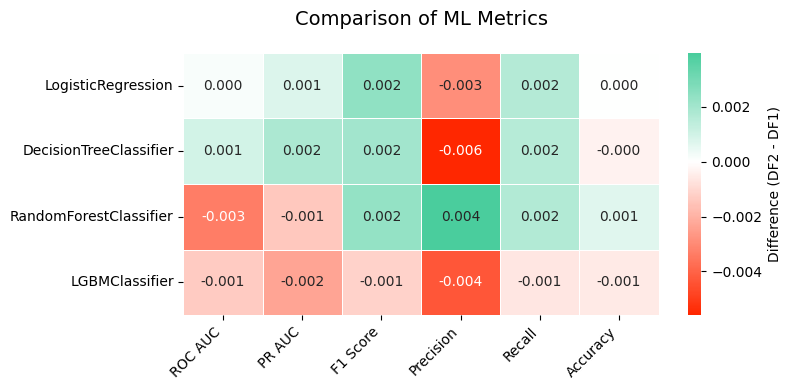

In [61]:
compare_metrics_heatmap(initial_metrics, lir_metrics)

В основном небольшие ухудшения

# FirstCall - первый звонок в кампании

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 17
[LightGBM] [Info] [bin

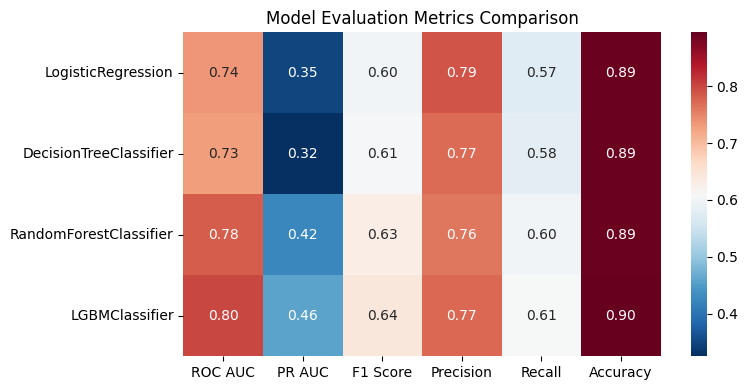

In [62]:
# 1 фича: первый звонок в кампании
X_1f = X.copy()
X_1f["FirstCall"] = (X_1f["campaign"].fillna(0) == 1).astype("int8")

preprocessor_1f = clone(preprocessor)  

ct = preprocessor_1f.named_steps["nan_remover"]
trs = list(ct.transformers)
for i, (name, trf, cols) in enumerate(trs):
    if name == "mean":
        cols = list(cols) + ["FirstCall"]
        trs[i] = (name, trf, cols)
        break
preprocessor_1f.set_params(nan_remover__transformers=trs)

metrics_1f = train_evaluate_models_cv(
    models=models,
    X=X_1f,
    y=y,
    preprocessor=preprocessor_1f,
    cv=cv,       
    seed=SEED
)


(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000922  0.001513  0.007388  -0.004627  0.005179   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.001321 -0.001109 -0.001140   0.000567 -0.000972   
 LGBMClassifier          0.000076  0.000232  0.000302  -0.000024  0.000259   
 
                         Accuracy  
 LogisticRegression      0.000310  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000022  
 LGBMClassifier          0.000022  )

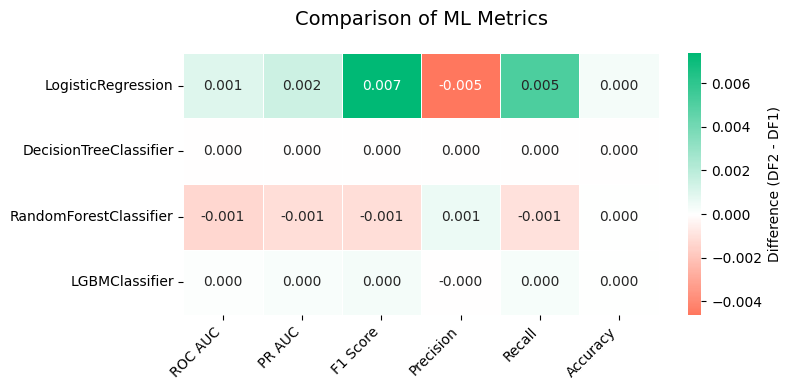

In [63]:
compare_metrics_heatmap(initial_metrics, metrics_1f)

Немного улучшился лес, ухудшилась регрессия

### 2.4 Биннинг 

#### 2.4.1 Без удаления

#### для campaign

In [201]:
x_binning = X.copy()
bins   = [-np.inf, 1, 3, 5, np.inf]
labels = [0, 1, 2, 3]

x_binning['campaign_bins'] = pd.cut(
    x_binning['campaign'], bins=bins, labels=labels
).astype('int16')
preprocessor_campaign_binning = clone(preprocessor)
preprocessor_campaign_binning['nan_remover'].transformers[0][2].append('campaign_bins')

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 17
[LightGBM] [Info] [bin

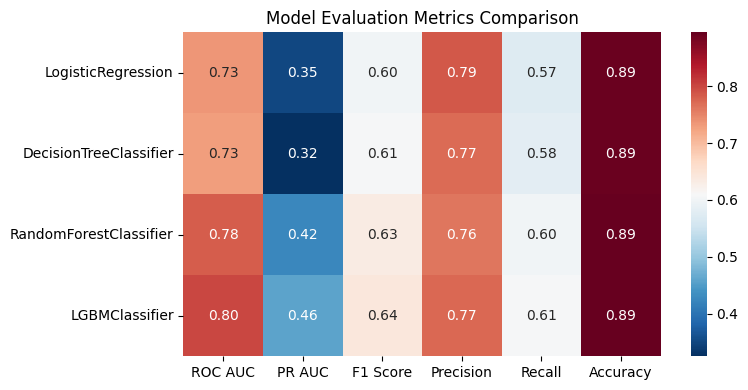

In [202]:
campaign_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=x_binning,
    y=y,
    preprocessor=preprocessor_campaign_binning,
    cv=cv,   
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000679  0.001956  0.005985  -0.006574  0.004222   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.002597 -0.000377  0.000901   0.001541  0.000630   
 LGBMClassifier         -0.000317  0.000884 -0.001044  -0.000497 -0.000827   
 
                         Accuracy  
 LogisticRegression      0.000066  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000243  
 LGBMClassifier         -0.000155  )

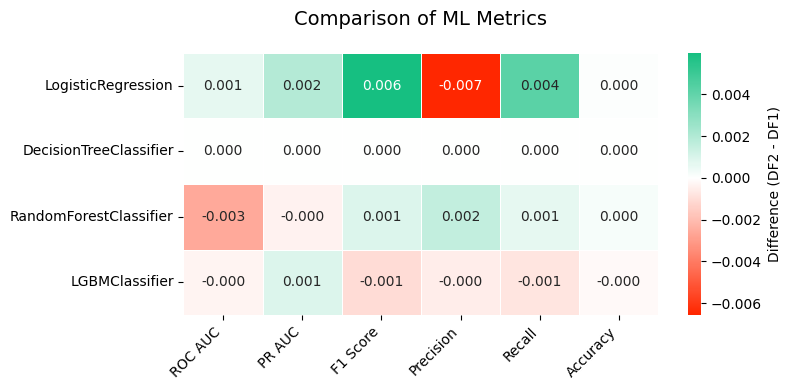

In [203]:
compare_metrics_heatmap(initial_metrics, campaign_binning_metrics)

#### для pdays

In [204]:
x_binning = X.copy()
B_PDAYSPOS = [-0.1, 5, 30, 90, 180, np.inf]

pdpos = x_binning['pdays'].where(df['pdays'] >= 0)
x_binning['pdays_pos_bins'] = pd.cut(pdpos, bins=B_PDAYSPOS, labels=False).astype('Int16')

preprocessor_campaign_binning = clone(preprocessor)
preprocessor_campaign_binning['nan_remover'].transformers[0][2].append('pdays_pos_bins')

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 17
[LightGBM] [Info] [bin

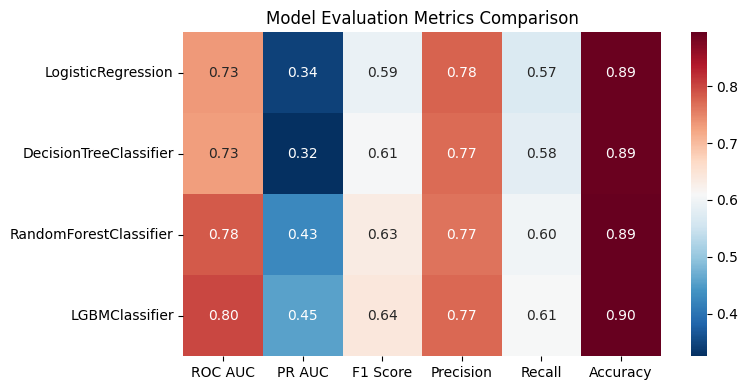

In [205]:
campaign_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=x_binning,
    y=y,
    preprocessor=preprocessor_campaign_binning,
    cv=cv,   
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000602 -0.004239 -0.002809  -0.015493 -0.001721   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.000037  0.001664  0.000333   0.004245 -0.000027   
 LGBMClassifier         -0.001124 -0.002034  0.000295   0.000120  0.000272   
 
                         Accuracy  
 LogisticRegression     -0.001305  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000531  
 LGBMClassifier          0.000044  )

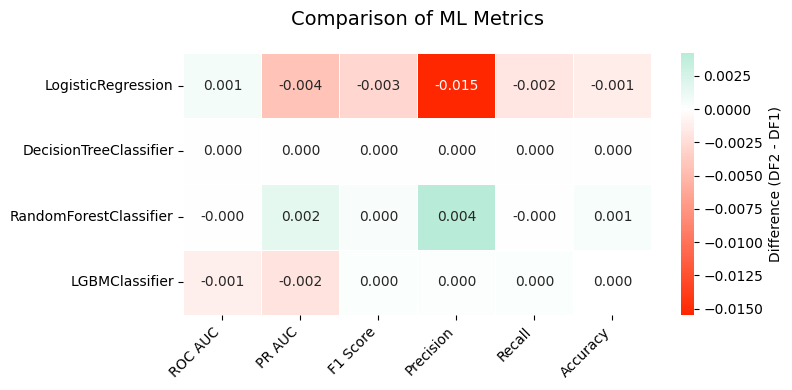

In [206]:
compare_metrics_heatmap(initial_metrics, campaign_binning_metrics)

#### previous

In [207]:
x_binning = X.copy()
B_PREV = [-0.1, 0, 1, 3, 5, np.inf]

x_binning['previous_bins'] = pd.cut(x_binning['previous'], bins=B_PREV, labels=False).astype('int16')
preprocessor_campaign_binning = clone(preprocessor)
preprocessor_campaign_binning['nan_remover'].transformers[0][2].append('previous_bins')

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 17
[LightGBM] [Info] [bin

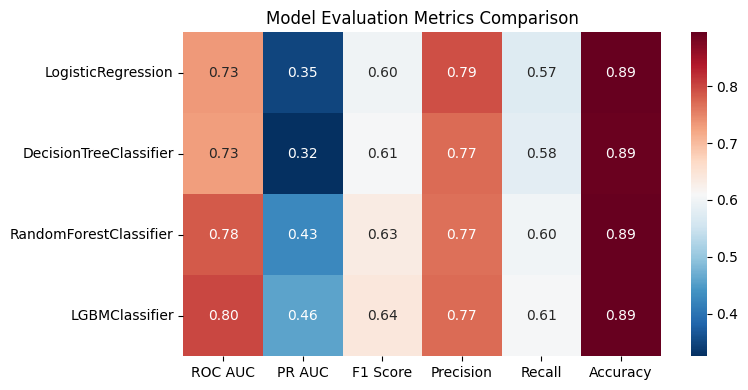

In [208]:
campaign_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=x_binning,
    y=y,
    preprocessor=preprocessor_campaign_binning,
    cv=cv,   
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000162  0.001405  0.005514   0.000408  0.003734   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.000332  0.000425  0.000099   0.004692 -0.000249   
 LGBMClassifier         -0.000777 -0.000537 -0.001093  -0.002137 -0.000762   
 
                         Accuracy  
 LogisticRegression      0.000509  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000575  
 LGBMClassifier         -0.000332  )

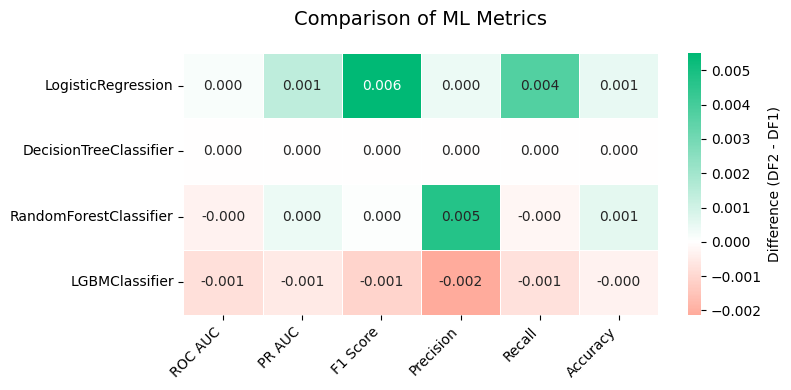

In [209]:
compare_metrics_heatmap(initial_metrics, campaign_binning_metrics)

#### age

In [210]:
x_binning = X.copy()
B_AGE = [-np.inf, 25, 35, 45, 55, 65, np.inf]

x_binning['age_bins']      = pd.cut(x_binning['age'],      bins=B_AGE,  labels=False).astype('int16')
preprocessor_campaign_binning = clone(preprocessor)
preprocessor_campaign_binning['nan_remover'].transformers[0][2].append('age_bins')

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 17
[LightGBM] [Info] [bin

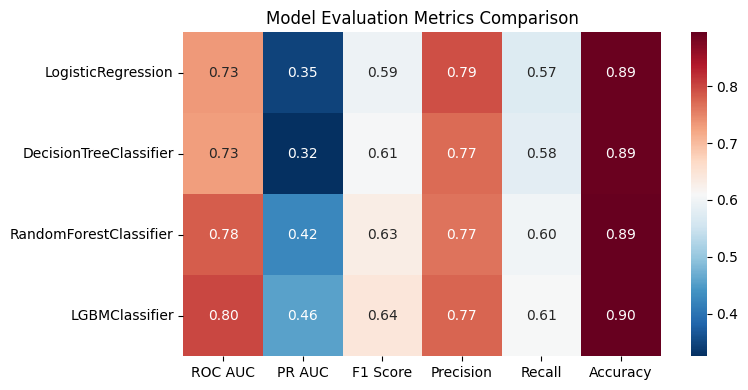

In [211]:
campaign_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=x_binning,
    y=y,
    preprocessor=preprocessor_campaign_binning,
    cv=cv,   
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression     -0.000333 -0.000637  0.001799  -0.000319  0.001307   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.001116 -0.001404 -0.001056   0.004189 -0.001156   
 LGBMClassifier         -0.000547 -0.000882  0.001125   0.000746  0.000908   
 
                         Accuracy  
 LogisticRegression      0.000133  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000420  
 LGBMClassifier          0.000155  )

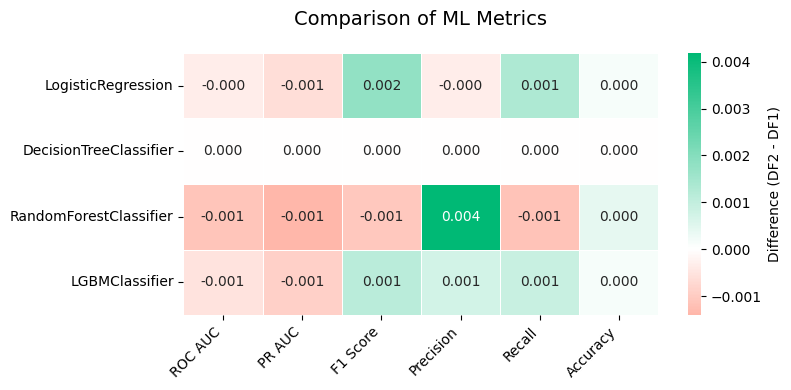

In [212]:
compare_metrics_heatmap(initial_metrics, campaign_binning_metrics)

#### balance

In [216]:
x_binning = X.copy()
q_balance  = x_binning['balance'].quantile([0.50, 0.75, 0.90, 0.95]).values
B_BAL = [-np.inf, *q_balance, np.inf]

x_binning['balance_bins']  = pd.cut(x_binning['balance'],  bins=B_BAL,  labels=False).astype('int16')
preprocessor_campaign_binning = clone(preprocessor)
preprocessor_campaign_binning['nan_remover'].transformers[0][2].append('balance_bins')

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 17
[LightGBM] [Info] [bin

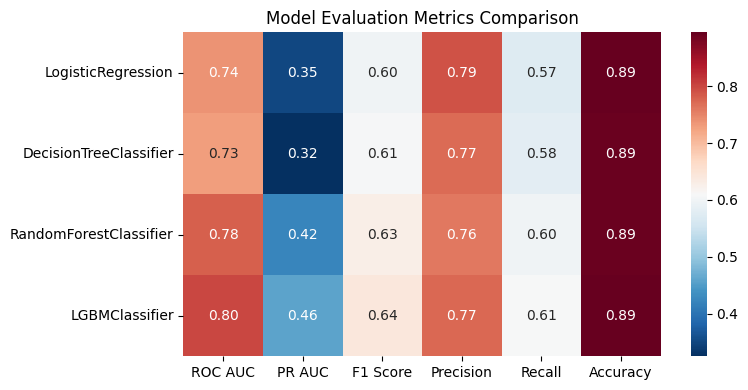

In [217]:
campaign_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=x_binning,
    y=y,
    preprocessor=preprocessor_campaign_binning,
    cv=cv,   
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.003722  0.002495  0.004263  -0.002500  0.002889   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.004472 -0.004156 -0.002204  -0.001387 -0.001709   
 LGBMClassifier         -0.000053  0.000762 -0.000272  -0.001508 -0.000125   
 
                         Accuracy  
 LogisticRegression      0.000177  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier -0.000265  
 LGBMClassifier         -0.000221  )

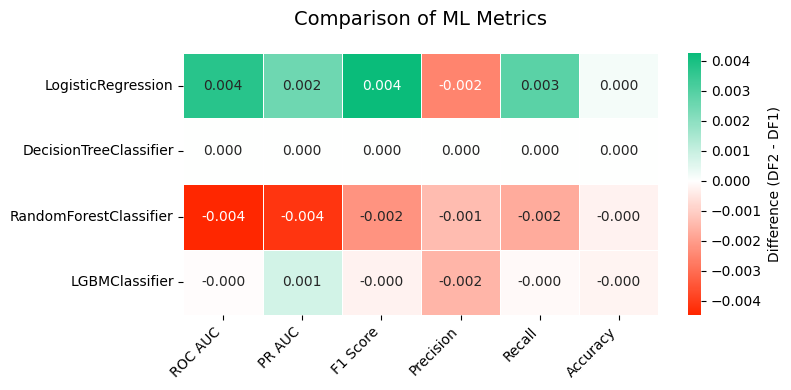

In [218]:
compare_metrics_heatmap(initial_metrics, campaign_binning_metrics)

Особых изменений нет

#### 2.4.2 С удалением

In [128]:
X_loan_amount_term_binning_del = X.copy()

In [129]:
bins = [-np.inf, 180, 360, np.inf]
labels = [0, 1, 2]

X_loan_amount_term_binning_del['campaign'] = pd.cut(X_loan_amount_term_binning_del['campaign'], bins=bins, labels=labels)

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 15
[LightGBM] [Info] [bin

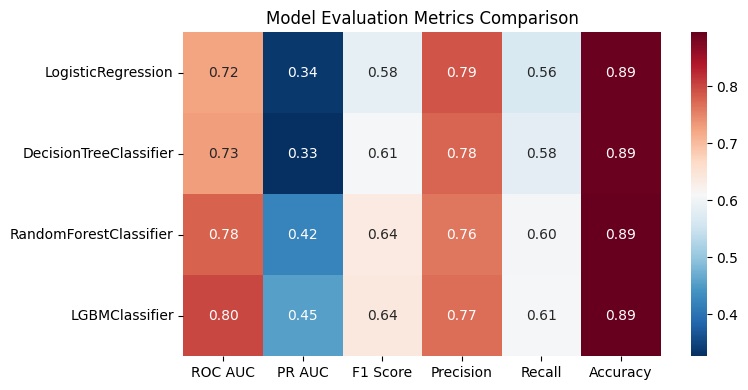

In [130]:
loan_amount_term_binning_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_loan_amount_term_binning_del,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression     -0.009589 -0.012333 -0.008712  -0.005065 -0.005298   
 DecisionTreeClassifier -0.000083  0.001176 -0.000613   0.004095 -0.000381   
 RandomForestClassifier -0.005968 -0.005291  0.004461  -0.000349  0.003759   
 LGBMClassifier         -0.001118 -0.002515 -0.001609  -0.004622 -0.001032   
 
                         Accuracy  
 LogisticRegression     -0.001106  
 DecisionTreeClassifier  0.000199  
 RandomForestClassifier  0.000265  
 LGBMClassifier         -0.000664  )

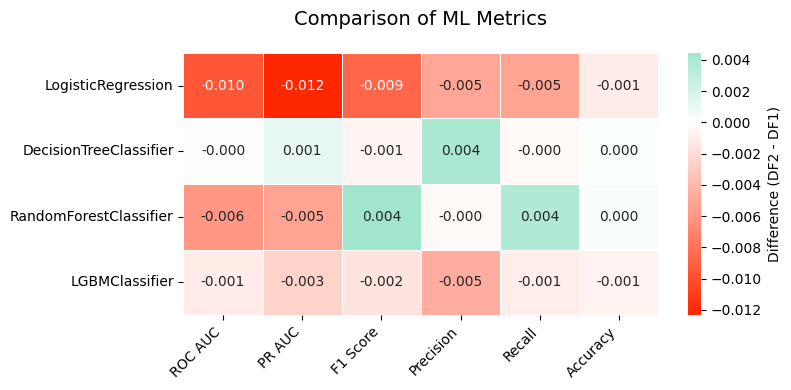

In [131]:
compare_metrics_heatmap(initial_metrics, loan_amount_term_binning_metrics_del)

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 15
[LightGBM] [Info] [bin

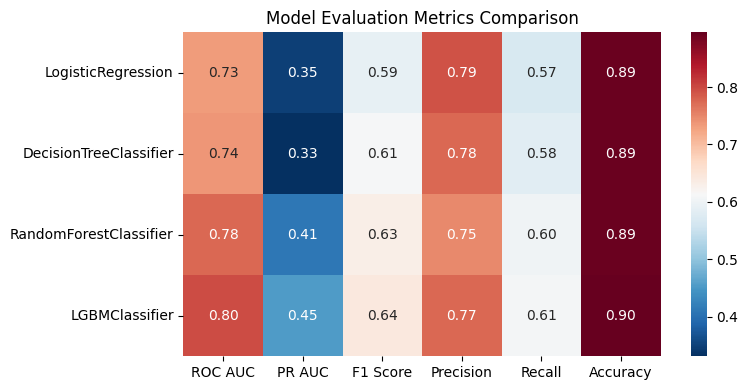

In [220]:
X_loan_amount_term_binning_del = X.copy()

B_AGE = [-np.inf, 25, 35, 45, 55, 65, np.inf]

X_loan_amount_term_binning_del['age'] = pd.cut(X_loan_amount_term_binning_del['age'], bins=bins, labels=False)

loan_amount_term_binning_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_loan_amount_term_binning_del,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression     -0.000256 -0.000672 -0.002169  -0.001298 -0.001379   
 DecisionTreeClassifier  0.007329  0.006648  0.002715   0.004565  0.001537   
 RandomForestClassifier -0.009584 -0.015919 -0.000553  -0.013161  0.000524   
 LGBMClassifier         -0.003944 -0.003969  0.000410   0.000487  0.000297   
 
                         Accuracy  
 LogisticRegression     -0.000265  
 DecisionTreeClassifier  0.000686  
 RandomForestClassifier -0.001681  
 LGBMClassifier          0.000088  )

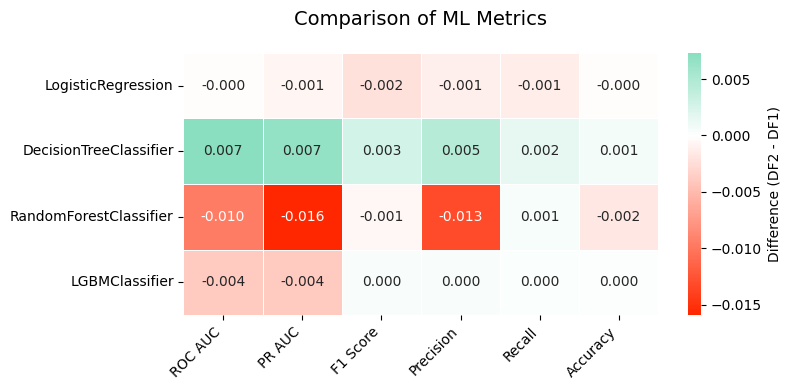

In [221]:
compare_metrics_heatmap(initial_metrics, loan_amount_term_binning_metrics_del)

### 2.5 Применение StandardScaler (стандартизация)

#### 2.5.1 Без удаления

In [132]:
X_standard_scaler = X.copy()

In [133]:
scaled_columns = ['balanceScaled', 'campaignScaled', 'previousScaled']
X_standard_scaler[scaled_columns] = X_standard_scaler[['balance', 'campaign', 'previous']]

In [134]:
preprocessor_standard_scaler = clone(preprocessor)

preprocessor_standard_scaler['transformations'].transformers.append(
    ('scaler', StandardScaler(), scaled_columns)
)

preprocessor_standard_scaler['nan_remover'].transformers[0][2].extend(scaled_columns)

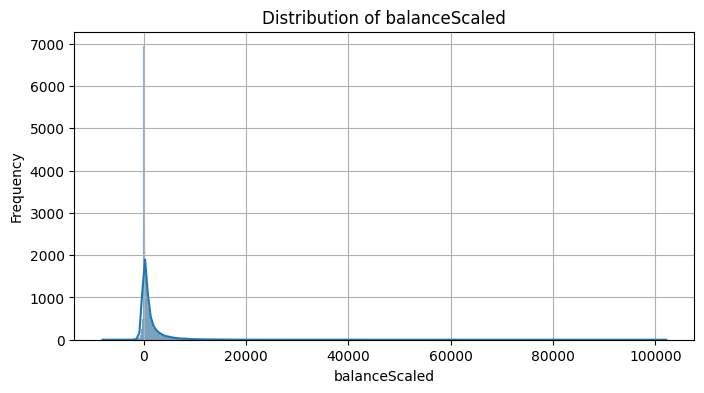

In [135]:
plot_hist_numeric(X_standard_scaler, 'balanceScaled')

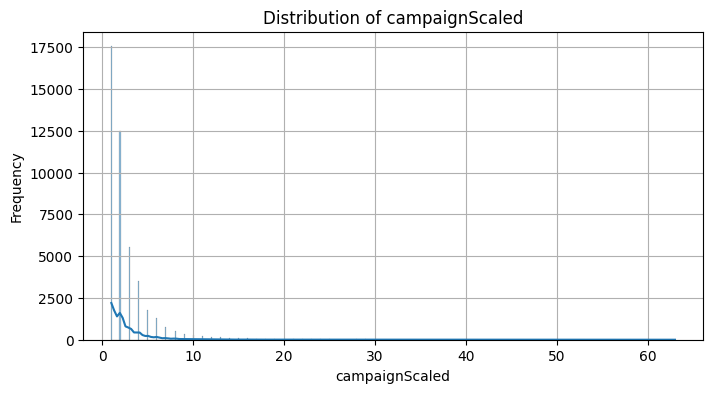

In [136]:
plot_hist_numeric(X_standard_scaler, 'campaignScaled')

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 19
[LightGBM] [Info] [b

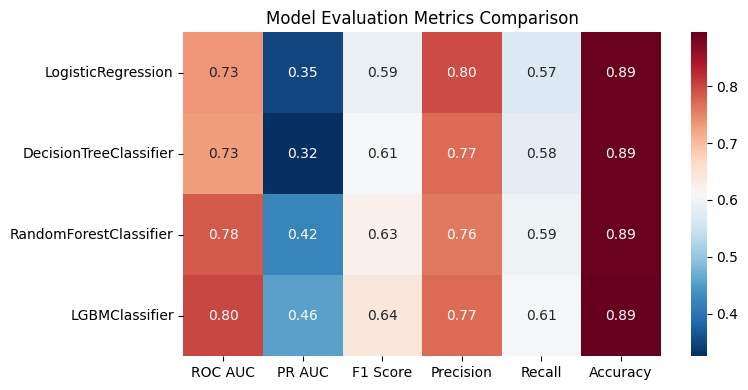

In [137]:
standard_scaler_metrics = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler,
    y=y,
    preprocessor=preprocessor_standard_scaler,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000717  0.001048 -0.004411   0.003110 -0.002994   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.000966 -0.003810 -0.006927  -0.000833 -0.005643   
 LGBMClassifier         -0.000991 -0.001562 -0.001177  -0.002098 -0.000844   
 
                         Accuracy  
 LogisticRegression     -0.000221  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier -0.000553  
 LGBMClassifier         -0.000332  )

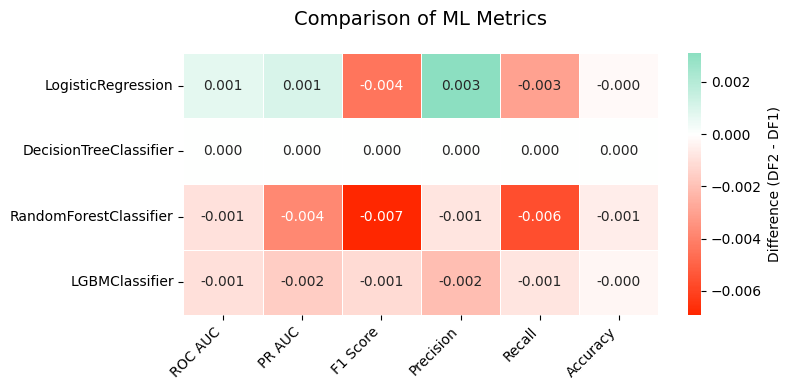

In [138]:
compare_metrics_heatmap(initial_metrics, standard_scaler_metrics)

В основном ухудшения

#### 2.5.2 С удалением

In [139]:
X_standard_scaler_del = X.copy()

In [140]:
preprocessor_standard_scaler_del = clone(preprocessor)

preprocessor_standard_scaler_del['transformations'].transformers.append(
    ('scaler', StandardScaler(), ['balance', 'campaign', 'previous'])
)

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [bin

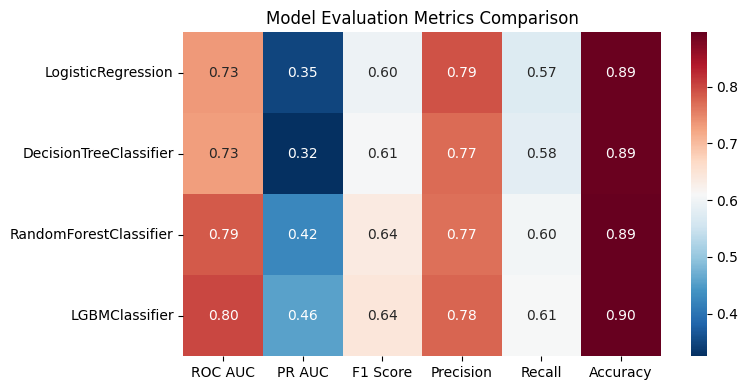

In [141]:
standard_scaler_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler_del,
    y=y,
    preprocessor=preprocessor_standard_scaler_del,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000519  0.000877  0.002758  -0.001865  0.001868   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier  0.000271 -0.000396  0.003387   0.006190  0.002368   
 LGBMClassifier         -0.000829 -0.001521  0.001016   0.002155  0.000692   
 
                         Accuracy  
 LogisticRegression      0.000111  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000995  
 LGBMClassifier          0.000354  )

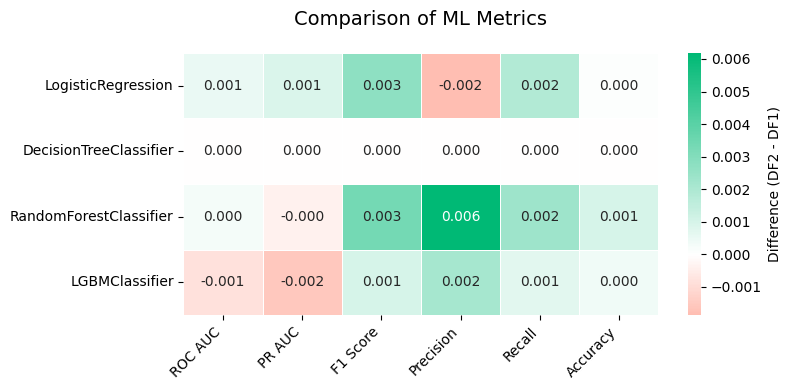

In [142]:
compare_metrics_heatmap(initial_metrics, standard_scaler_metrics_del)

Небольшие колебания в бустинге, небольшие улучшения в лесе

### 2.6 Нормализация

#### 2.6.1 Без удаления

In [143]:
X_normalised = X.copy()

In [144]:
scaled_columns = ['balanceScaled', 'campaignScaled', 'previousScaled']
X_normalised[scaled_columns] = X_normalised[['balance', 'campaign', 'previous']]

In [145]:
preprocessor_normalisation = clone(preprocessor)

preprocessor_normalisation['transformations'].transformers.append(
    ('scaler', MinMaxScaler(), scaled_columns)
)

preprocessor_normalisation['nan_remover'].transformers[0][2].extend(scaled_columns)

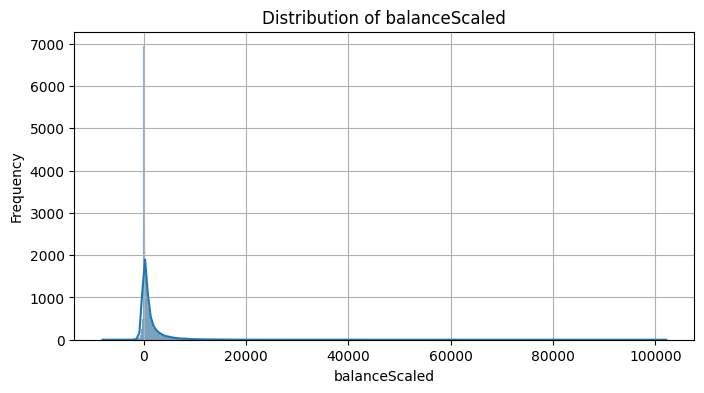

In [146]:
plot_hist_numeric(X_normalised, 'balanceScaled')

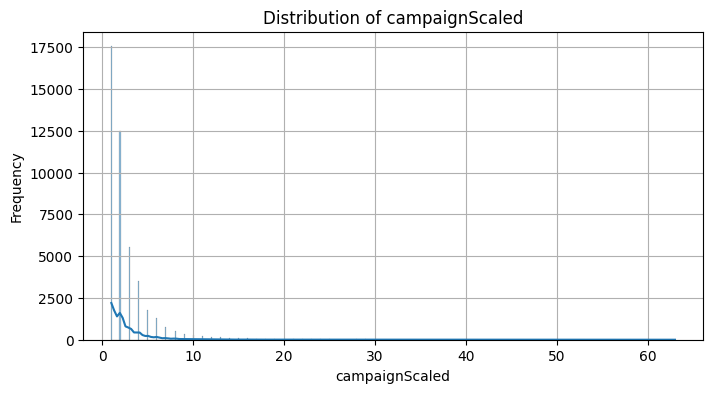

In [147]:
plot_hist_numeric(X_normalised, 'campaignScaled')

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 19
[LightGBM] [Info] [b

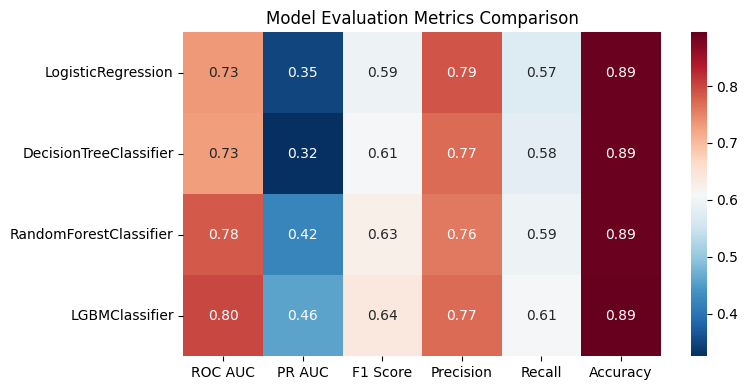

In [148]:
normalised_metrics = train_evaluate_models_cv(
    models=models,
    X=X_normalised,
    y=y,
    preprocessor=preprocessor_normalisation,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000185 -0.000289  0.001489  -0.004679  0.001036   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.001037 -0.003734 -0.006583  -0.000693 -0.005372   
 LGBMClassifier         -0.000775  0.000594 -0.002270  -0.002557 -0.001739   
 
                         Accuracy  
 LogisticRegression     -0.000199  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier -0.000509  
 LGBMClassifier         -0.000464  )

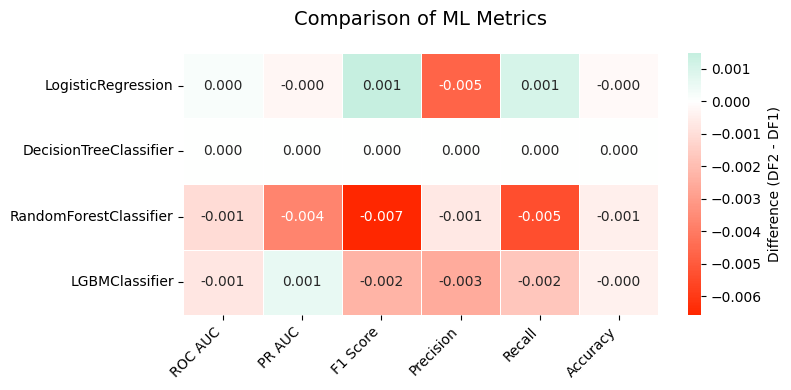

In [149]:
compare_metrics_heatmap(initial_metrics, normalised_metrics)

В основном только ухудшение метрик

#### 2.6.2 С удалением

In [150]:
X_normalised_del = X.copy()

In [151]:
preprocessor_normalisation_del = clone(preprocessor)

preprocessor_normalisation_del['transformations'].transformers.append(
    ('scaler', MinMaxScaler(), ['balance', 'campaign', 'previous'])
)

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [bin

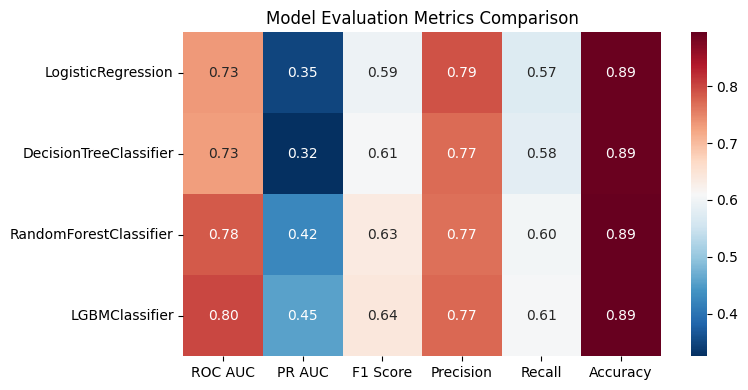

In [152]:
normalised_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_normalised_del,
    y=y,
    preprocessor=preprocessor_normalisation_del,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression     -0.000293 -0.000069  0.002120  -0.003171  0.001452   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier  0.000141 -0.000424  0.002841   0.004835  0.002010   
 LGBMClassifier         -0.001600 -0.002203 -0.001284  -0.001580 -0.000983   
 
                         Accuracy  
 LogisticRegression     -0.000044  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000796  
 LGBMClassifier         -0.000288  )

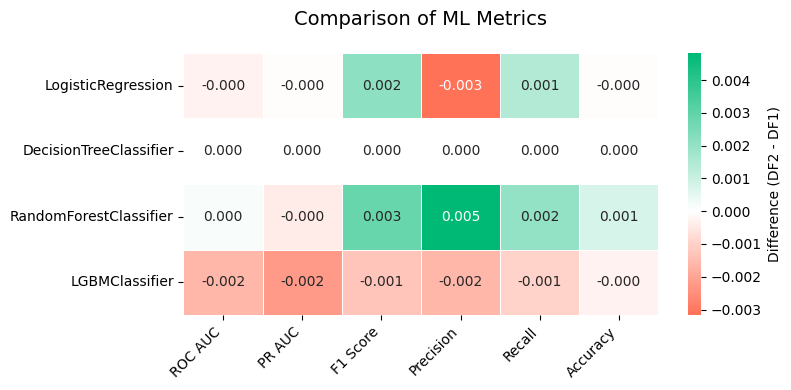

In [153]:
compare_metrics_heatmap(initial_metrics, normalised_metrics_del)

### 2.7 Обработка выбросов

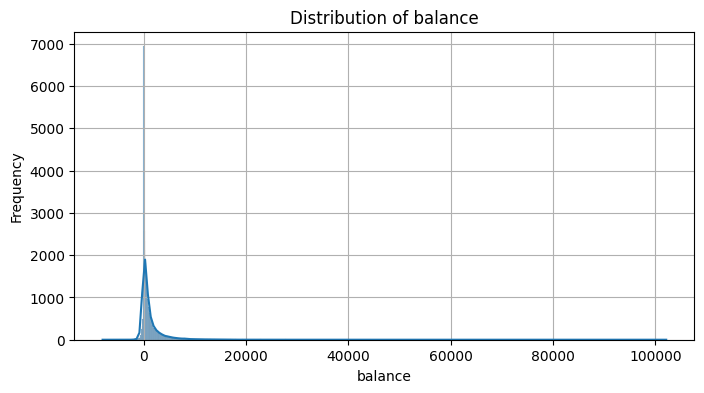

In [154]:
# посмотреть, как изменилась одна из фич
plot_hist_numeric(X, 'balance')

In [155]:
X_no_outliers = X.copy()
robust_cols = ['balance', 'campaign', 'previous']

prep_rs = clone(preprocessor)        
prep_rs.set_output(transform='pandas')

prep_rs['transformations'].transformers = [
    t for t in prep_rs['transformations'].transformers
    if t[0] not in ('scaler', 'robust_scale')
]

# Добавляем RobustScaler
prep_rs['transformations'].transformers.append(
    ('robust_scale', RobustScaler(quantile_range=(25, 75)), robust_cols)
)

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [bin

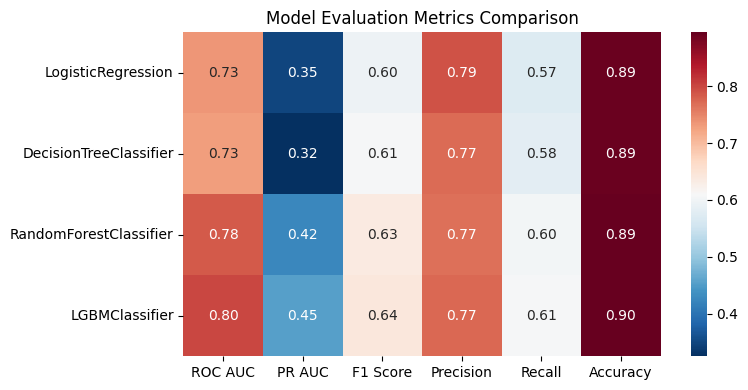

In [156]:
no_outliers_metrics = train_evaluate_models_cv(
    models=models,
    X=X_no_outliers,
    y=y,
    preprocessor=prep_rs,
    cv=cv,
    seed=SEED
)

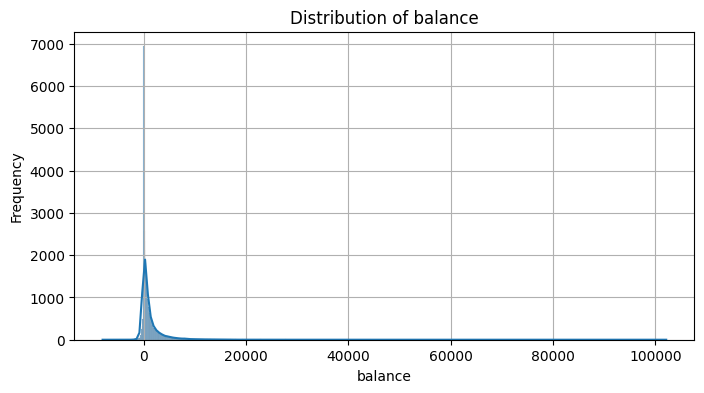

In [157]:
# посмотреть, как изменилась одна из фич
plot_hist_numeric(X_no_outliers, 'balance')

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000567  0.000917  0.002304  -0.001527  0.001528   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier  0.000137 -0.000358  0.002837   0.005400  0.001965   
 LGBMClassifier         -0.001375 -0.003557 -0.000953   0.000254 -0.000845   
 
                         Accuracy  
 LogisticRegression      0.000088  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000863  
 LGBMClassifier         -0.000044  )

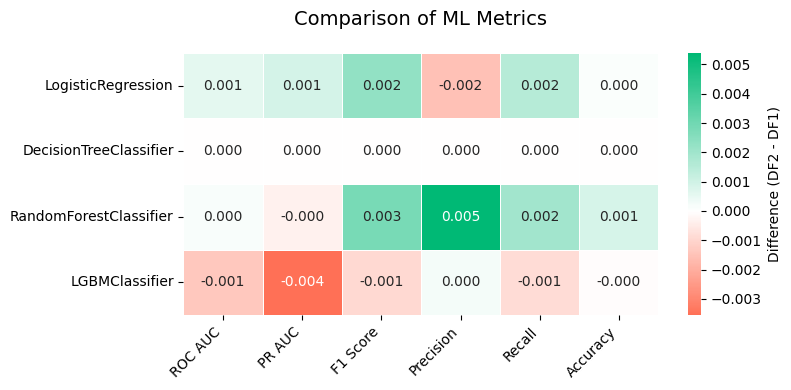

In [158]:
compare_metrics_heatmap(initial_metrics, no_outliers_metrics)

Ухудшения в бустинге и небольшие улучшения в лесе

### 2.9 Таргетное кодирование

In [159]:
preprocessor_target_encoding = clone(preprocessor)
preprocessor_target_encoding['transformations'].transformers[0] = ('encoder', TargetEncoder(categories=cat_orders), categorical_cols)

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [bin

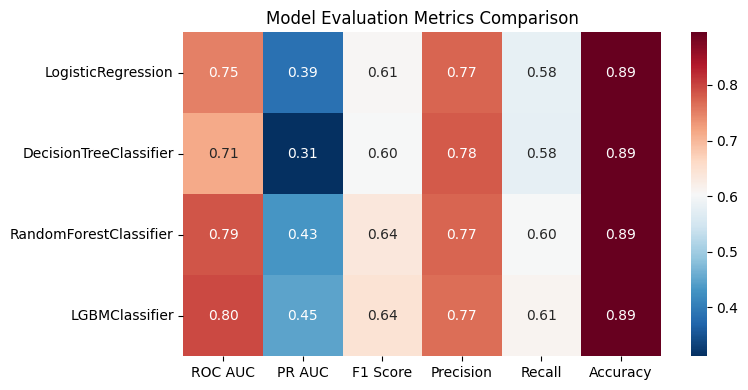

In [160]:
target_encoder_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor_target_encoding,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.014785  0.037630  0.014649  -0.019985  0.010720   
 DecisionTreeClassifier -0.016177 -0.012416 -0.005315   0.009423 -0.004181   
 RandomForestClassifier  0.001913  0.005669  0.003702   0.010922  0.002340   
 LGBMClassifier         -0.004941 -0.008723  0.001758  -0.007685  0.002200   
 
                         Accuracy  
 LogisticRegression     -0.000332  
 DecisionTreeClassifier  0.000288  
 RandomForestClassifier  0.001526  
 LGBMClassifier         -0.000752  )

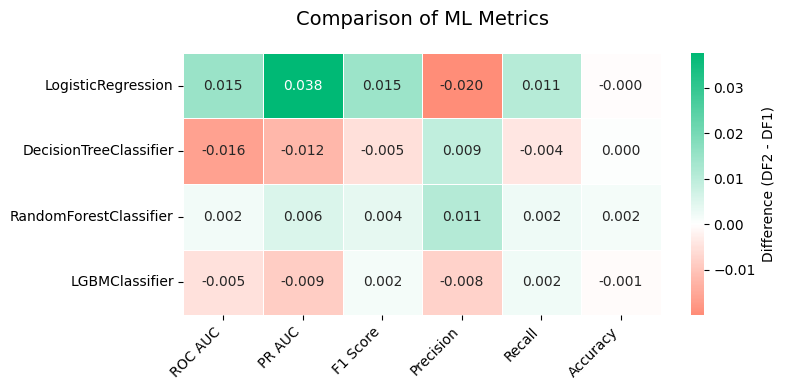

In [161]:
compare_metrics_heatmap(initial_metrics, target_encoder_metrics)

### 2.10 Работа с дисбалансом классов

#### 2.10.1 На уровне моделей

In [162]:
models_balanced = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear', class_weight='balanced')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4, class_weight='balanced')),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('LGBMClassifier', LGBMClassifier(random_state=SEED, class_weight='balanced'))
]

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [binar

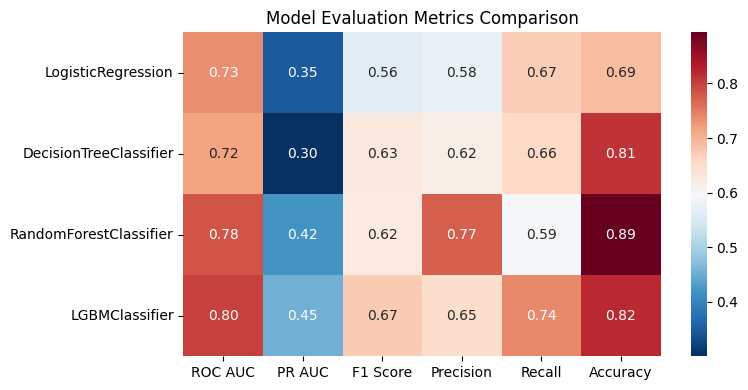

In [163]:
balanced_metrics = train_evaluate_models_cv(
    models=models_balanced,
    X=X,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000892 -0.000324 -0.030280  -0.215673  0.101130   
 DecisionTreeClassifier -0.013416 -0.024265  0.019280  -0.155585  0.075799   
 RandomForestClassifier -0.001956 -0.004283 -0.007756   0.013134 -0.007043   
 LGBMClassifier         -0.002361 -0.003085  0.030341  -0.124884  0.130475   
 
                         Accuracy  
 LogisticRegression     -0.203623  
 DecisionTreeClassifier -0.079627  
 RandomForestClassifier  0.000885  
 LGBMClassifier         -0.073301  )

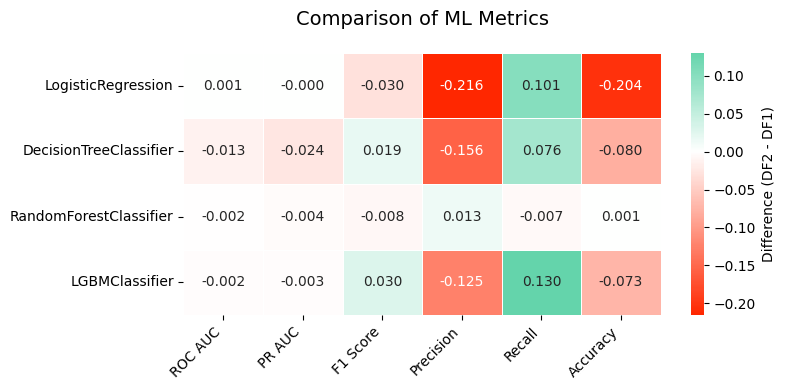

In [164]:
compare_metrics_heatmap(initial_metrics, balanced_metrics)

#### 2.10.2 Используя SMOTE

In [165]:
preprocessor_smote = clone(preprocessor)

preprocessor_smote.steps.append(
    ('smote', SMOTE(random_state=SEED))
)

[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2990
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

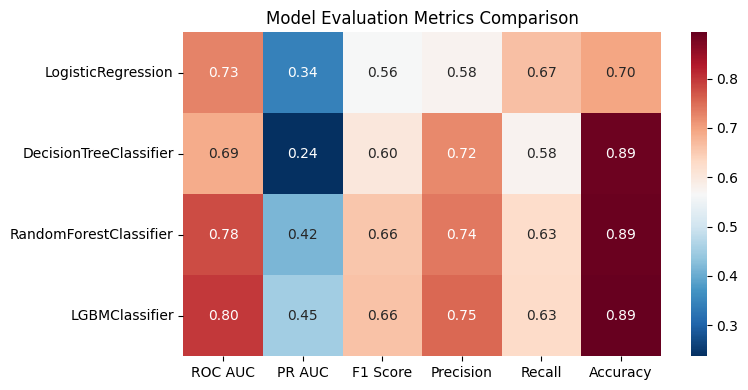

In [166]:
smote_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor_smote,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression     -0.005267 -0.003278 -0.028472  -0.216787  0.095840   
 DecisionTreeClassifier -0.041756 -0.087482 -0.004932  -0.047024 -0.002309   
 RandomForestClassifier -0.004343 -0.008945  0.025562  -0.022991  0.025888   
 LGBMClassifier         -0.004048 -0.006684  0.019374  -0.020372  0.019960   
 
                         Accuracy  
 LogisticRegression     -0.196744  
 DecisionTreeClassifier -0.005242  
 RandomForestClassifier -0.002079  
 LGBMClassifier         -0.001393  )

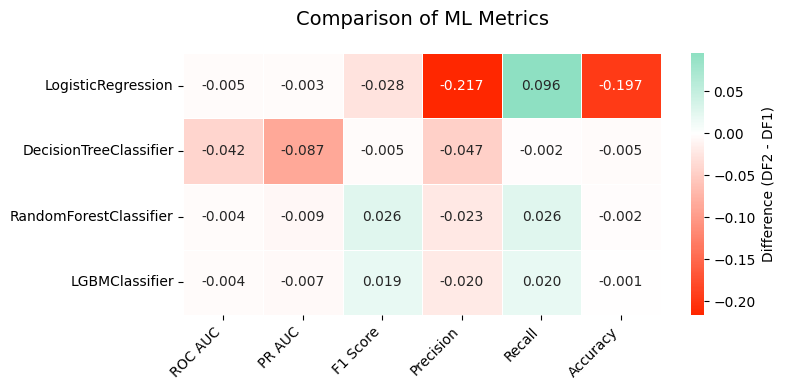

In [167]:
compare_metrics_heatmap(initial_metrics, smote_metrics)

In [124]:
from imblearn.pipeline import Pipeline as ImbPipeline

[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2990
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 31938, number of neg

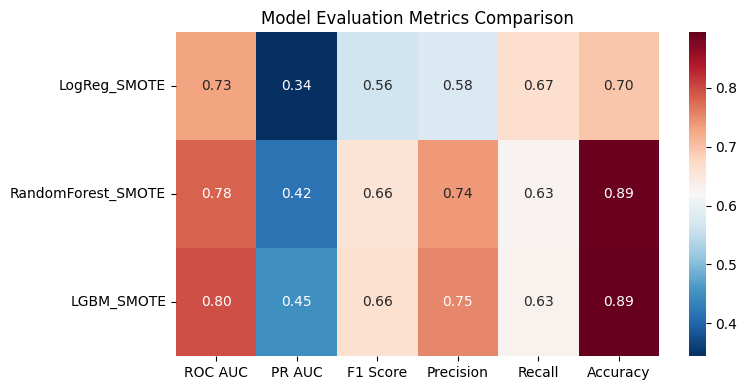

,ROC AUC,PR AUC,F1 Score,Precision,Recall,Accuracy
LogReg_SMOTE,0.728837,0.344333,0.564275,0.576880,0.665464,0.695826
RandomForest_SMOTE,0.780487,0.416242,0.657614,0.738651,0.625983,0.890713
LGBM_SMOTE,0.797000,0.450277,0.662162,0.753861,0.628164,0.893698


In [125]:
lr_smote = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=SEED, k_neighbors=5)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear', random_state=SEED))
])

rf_smote = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=SEED)),
    ('clf', RandomForestClassifier(random_state=SEED))
])

lgbm_smote = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=SEED)),
    ('clf', LGBMClassifier(random_state=SEED))
])

models_smote = [
    ('LogReg_SMOTE', lr_smote),
    ('RandomForest_SMOTE', rf_smote),
    ('LGBM_SMOTE', lgbm_smote),
]

smote_metrics = train_evaluate_models_cv(
    models=models_smote,
    X=X, y=y,
    preprocessor=preprocessor,
    cv=cv, seed=SEED
)
smote_metrics

In [126]:
smote_metrics_renamed = smote_metrics.rename(index={
    'LogReg_SMOTE': 'LogisticRegression',
    'RandomForest_SMOTE': 'RandomForestClassifier',
    'LGBM_SMOTE': 'LGBMClassifier'
})

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 DecisionTreeClassifier       NaN       NaN       NaN        NaN       NaN   
 LGBMClassifier         -0.004048 -0.006684  0.019374  -0.020372  0.019960   
 LogisticRegression     -0.005267 -0.003278 -0.028472  -0.216787  0.095840   
 RandomForestClassifier -0.004343 -0.008945  0.025562  -0.022991  0.025888   
 
                         Accuracy  
 DecisionTreeClassifier       NaN  
 LGBMClassifier         -0.001393  
 LogisticRegression     -0.196744  
 RandomForestClassifier -0.002079  )

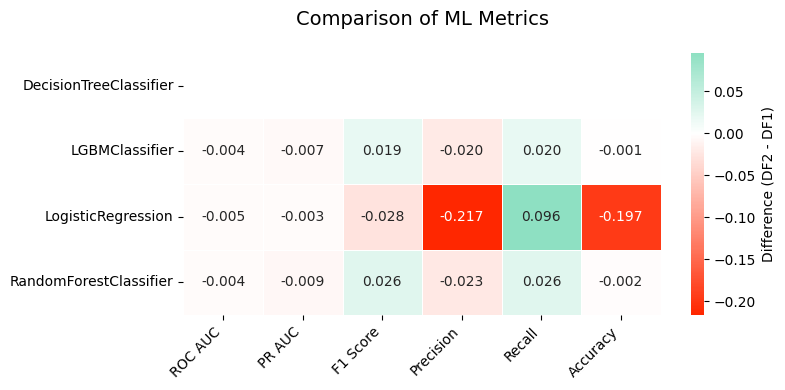

In [127]:
compare_metrics_heatmap(initial_metrics, smote_metrics_renamed)

### 2.11 Итоговый результат

Из всех преобразований только стандартизация с удалением дал хоть какие-то улучшения, его мы и применим к данным

In [222]:
X_final = X.copy()

In [223]:
preprocessor_final = clone(preprocessor)

preprocessor_final['transformations'].transformers.append(
    ('scaler', StandardScaler(), ['balance', 'campaign', 'previous'])
)

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 16
[LightGBM] [Info] [bin

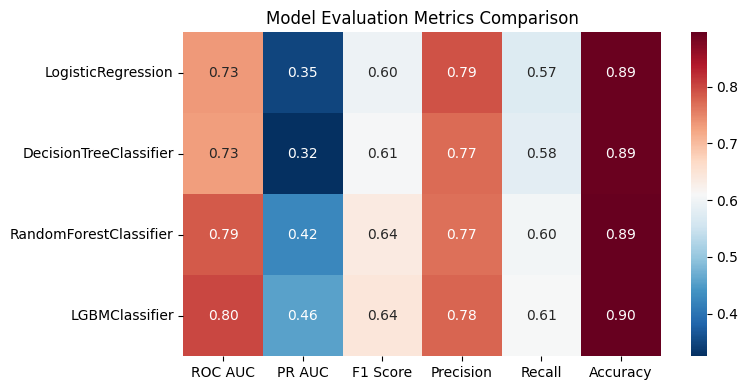

In [224]:
final_metrics = train_evaluate_models_cv(
    models=models,
    X=X_final,
    y=y,
    preprocessor=preprocessor_final,
    cv=cv,   
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.000519  0.000877  0.002758  -0.001865  0.001868   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier  0.000271 -0.000396  0.003387   0.006190  0.002368   
 LGBMClassifier         -0.000829 -0.001521  0.001016   0.002155  0.000692   
 
                         Accuracy  
 LogisticRegression      0.000111  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000995  
 LGBMClassifier          0.000354  )

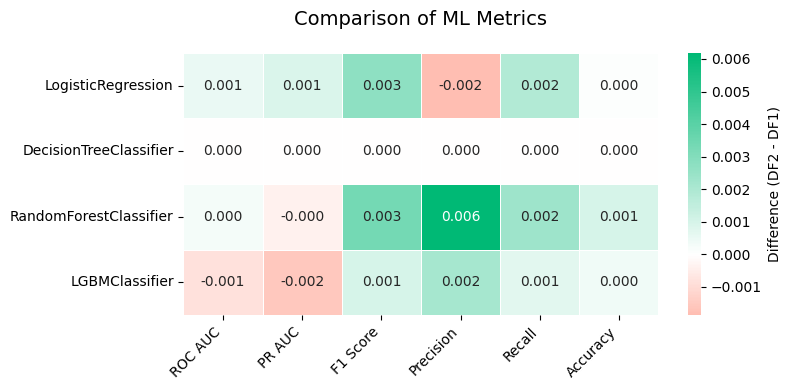

In [225]:
compare_metrics_heatmap(initial_metrics, final_metrics)